In [70]:
import os
import sys
import copy
import json
import time
import shutil

import torch
from torch.autograd import Variable
from torch import optim
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Fix sibling directory imports
cwd = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(cwd, '..'))

from src.datautils.sandia import SandiaDataProvider
from src.utils import show_batch_of_images
from src.models import mlp_net as mlp
from src.reasoning_agents import FFNReasoningAgent, RNN_RA
from src.autoencoders import PCA_autoencoder
from src.utils import show_batch_of_images, dict_of_lists_to_list_of_dicts

In [71]:
def train_reasoning_agent(model, img_size, encoding_size, batch_size, hidden_dim, learning_rate, optimizer,
                         num_epochs, early_stopping=True, early_stopping_epoch_patience=5):
    torch.manual_seed(123)

    train_data = SandiaDataProvider(which_set='train', dataset_home='../../datasets/sandia/',
                                    img_size=img_size)
    val_data = SandiaDataProvider(which_set='valid', dataset_home='../../datasets/sandia/',
                                  img_size=img_size)

    # These are in the shape <num_questions, imsize, imsize, 16(8Q + 8A)> - transpose and reshape so that they are
    # in the shape <num_images, img_size **2 >
    X = train_data.inputs.transpose(3, 0, 1, 2).reshape(-1, img_size ** 2)

    # "Fit" autoencoder to training images
    enc = PCA_autoencoder(encoding_size)
    enc.train(X)
    
    ###
    # Encode all validation inputs and answers so that this is not done in the training loop
    val_inputs_enc = enc.encode(val_data.inputs[..., :8].transpose(0, 3, 1, 2).reshape(-1, img_size ** 2))
    val_inputs_enc = Variable(torch.Tensor(val_inputs_enc.reshape(len(val_data.inputs), -1, encoding_size)),
                              volatile=True).cuda()
    val_answers = val_data.inputs[..., 8:].transpose(0, 3, 1, 2)
    val_correct_indices = val_data.targets
    val_answers_enc = enc.encode(val_answers.reshape(-1, img_size ** 2)).reshape(len(val_answers), -1,
                                                                                 encoding_size)
    val_correct_answers = val_answers[range(len(val_data.inputs)), val_data.targets].reshape(-1, img_size ** 2)
    val_correct_answers_enc = Variable(torch.Tensor(enc.encode(val_correct_answers)), volatile=True).cuda()
    ###
    
    ##
    # Variables for trackins statistics
    train_losses = []
    valid_losses = []
    datapoints_processed = []
    accs = []
        
    num_datapoints_processed = 0
    best_val_loss = None
    best_ep = None
    best_model = None
    best_acc = None
    ##
    
    for ep in range(num_epochs):
        for (inputs, answers), correct_indices in (train_data.get_batch_iterator(batch_size=batch_size,
                                                                                 transpose_inputs=True,
                                                                                 separate_inputs=True)):

            # Get the correct answers for each example in the batch and encode them
            # Then reshape them to batch_sizex1xencoding_size
            correct_answers = answers[range(batch_size), list(correct_indices)]
            encoded_correct = enc.encode(correct_answers.reshape(batch_size, img_size ** 2))
            encoded_correct = Variable(torch.Tensor(encoded_correct), requires_grad=False).cuda().view(
                batch_size, -1, encoding_size
            )

            # Encode all inputs in the batch and resape back to batch_size, num_images, encoding_size
            encoded_inputs = enc.encode(inputs.reshape(-1, img_size ** 2))
            encoded_inputs = Variable(torch.Tensor(encoded_inputs.reshape(batch_size, -1, encoding_size)),
                                      requires_grad=False).cuda()

            # Reset the gradiens in prep for a new step
            model.zero_grad()

            # Forward pass
            prediction = model(encoded_inputs)

            # Calculate training loss
            loss = torch.mean((encoded_correct - prediction) ** 2)

            # Compute gradients
            loss.backward()

            # Perform update step
            optimizer.step()

            # Calculate predictions 
            val_pred = model(val_inputs_enc)
            
            # Update validation loss
            val_loss = torch.mean((val_correct_answers_enc - val_pred.view_as(val_correct_answers_enc)) ** 2)
            
            # Record validation accuracy
            sqerr = np.mean((val_answers_enc - val_pred.cpu().data.numpy()) ** 2, 2)
            # Get the index of the least sq.err for each batch
            choice_indices = sqerr.argmin(1)
            
            ##
            # Record stats
            tot_correct = np.sum(val_correct_indices == choice_indices)
            acc = tot_correct / len(val_answers)
            accs.append(acc)
            
            train_losses.append(loss.data[0])
            valid_losses.append(val_loss.data[0])
            num_datapoints_processed += batch_size
            datapoints_processed.append(num_datapoints_processed)
                        
            if best_val_loss is None or val_loss.data[0] < best_val_loss:
                best_val_loss = val_loss.data[0]
                best_loss_ep = ep
            if best_acc is None or best_acc < acc:
                best_acc = acc
                best_acc_ep = ep
                best_model = copy.deepcopy(model)
            ##
            
            # Check early stopping criteria -- if neither the loss has decreased nor the accuracy
            # has gone up -- terminate training
            if early_stopping and ((ep - best_loss_ep) > early_stopping_epoch_patience) and ((ep - best_acc_ep) > early_stopping_epoch_patience):
                return best_model, datapoints_processed, train_losses, valid_losses, accs, best_val_loss, best_acc, best_acc_ep + 1, ep + 1, enc
        
        # Record validation accuracy
        sqerr = np.mean((val_answers_enc - val_pred.cpu().data.numpy()) ** 2, 2)
        # Get the index of the least sq.err for each batch
        choice_indices = sqerr.argmin(1)

        tot_correct = np.sum(val_correct_indices == choice_indices)
        accs.append(tot_correct / len(val_answers))
            
    
    return best_model, datapoints_processed, train_losses, valid_losses, accs, best_val_loss, best_acc, best_acc_ep + 1, ep + 1, enc


In [72]:
def train_iteration(hyperparams, res_folder, save=True, plot=False):
    img_size = hyperparams['img_size']
    encoding_size = hyperparams['encoding_size']
    batch_size = hyperparams['batch_size']
    hidden_dim = hyperparams['hidden_dim']
    learning_rate = hyperparams['learning_rate']
    momentum = hyperparams['momentum']
    weight_decay = hyperparams['weight_decay']
    num_epochs = hyperparams['num_epochs']
    num_hidden_layers = hyperparams['num_hidden_layers']
    agent_type = hyperparams['agent_type']
    network_type = hyperparams['network_type']
    patience = hyperparams['patience_epochs']
    
    if agent_type == 'rnn':
        model = RNN_RA(hidden_dim=hidden_dim, input_size=encoding_size, batch_size=batch_size, network_type='vanilla')
    else:
        model = FFNReasoningAgent(encoding_size, hidden_dim, num_hidden=num_hidden_layers, nonlinearity=None)
    model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    start = time.time()
    res = train_reasoning_agent(
        model, img_size, encoding_size, batch_size, hidden_dim, learning_rate, optimizer, num_epochs,
        early_stopping=True, early_stopping_epoch_patience=patience
    )
    best_model, dp, train_losses, valid_losses, accs, best_val_loss, best_acc, best_ep, ep_trained_for, enc = res
    end = time.time()

    print(f'{(end - start):.1f} seconds: Training stopped after {ep_trained_for} epochs'+
          f' Best val loss: {best_val_loss:.3f}' +
         f'Best accuracy: {best_acc:.3f} at epoch {best_ep}')
    
    if save:
        # Save model
        torch.save(best_model.state_dict(), res_folder + '/best_models/' + str(hyperparams['id']) + '.sd')

        # Save results
        hyperparams['time_sec'] = end - start
        hyperparams['best_val_loss'] = best_val_loss
        hyperparams['best_acc'] = best_acc
        hyperparams['best_epoch'] = best_ep
        hyperparams['epochs_tained_for'] = ep_trained_for

        hyperparams['losses'] = {
            'train_loss': train_losses,
            'val_loss': valid_losses,
            'val_acc': accs
        }


        with open(res_folder + str(hyperparams['id']) + '.json', 'w+') as fp:
            json.dump(hyperparams, fp, indent=2)
    
    if plot:
        fig, axs = plt.subplots(2, 1, figsize=(14, 8))
        axs[0].grid()
        axs[1].grid()

        axs[0].plot(dp, train_losses);
        axs[0].plot(dp, valid_losses);
        axs[1].plot(accs);

In [88]:
hyperparams = {
    'img_size': [28],
    'encoding_size': [50, 100, 150, 200, 250, 300, 400],
    'hidden_dim': [50, 100, 150, 200, 250, 300],
    'num_hidden_layers': [1, 2, 3, 4],
    'agent_type': ['ff'],
    'network_type': ['vanilla'],
    
    'learning_rate': [0.001, 0.05, 0.1, 0.5, 1],
    'momentum': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'weight_decay': [0, 0.1, 0.3, 0.5, 0.7, 0.9],
    'num_epochs': [60],
    'batch_size': [4, 8, 16, 32, 64],
    'patience_epochs': [5]
}

In [73]:
save = True
plot = False

if save:
    folder = 'results/test/'
    if not os.path.exists(folder + '/best_models'):
        os.makedirs(folder + '/best_models')
    
num_models = len(os.listdir(folder)) - 1
hypers_list = dict_of_lists_to_list_of_dicts(hyperparams)
for i, h in enumerate(hypers_list):
    print(f'{i+1} out of {len(hypers_list)}:')
    h['id'] = num_models + i
    try:
        train_iteration(h, folder, save=save, plot=plot)
    except Exception:
        print('OOPS!')

1 out of 120:
9.0 seconds: Training stopped after 21 epochs Best val loss: 4.129Best accuracy: 0.619 at epoch 15
2 out of 120:
6.3 seconds: Training stopped after 15 epochs Best val loss: 3.960Best accuracy: 0.583 at epoch 9
3 out of 120:
5.6 seconds: Training stopped after 14 epochs Best val loss: 3.951Best accuracy: 0.536 at epoch 7
4 out of 120:
7.2 seconds: Training stopped after 15 epochs Best val loss: 4.049Best accuracy: 0.488 at epoch 8
5 out of 120:
6.4 seconds: Training stopped after 15 epochs Best val loss: 3.848Best accuracy: 0.440 at epoch 9
6 out of 120:
6.6 seconds: Training stopped after 18 epochs Best val loss: 3.822Best accuracy: 0.464 at epoch 12
7 out of 120:
OOPS!
8 out of 120:
6.8 seconds: Training stopped after 16 epochs Best val loss: 4.221Best accuracy: 0.595 at epoch 10
9 out of 120:
6.5 seconds: Training stopped after 17 epochs Best val loss: 4.058Best accuracy: 0.583 at epoch 11
10 out of 120:
4.8 seconds: Training stopped after 7 epochs Best val loss: 5.265

10.4 seconds: Training stopped after 30 epochs Best val loss: 4.182Best accuracy: 0.464 at epoch 22
88 out of 120:
OOPS!
89 out of 120:
5.1 seconds: Training stopped after 9 epochs Best val loss: 4.975Best accuracy: 0.298 at epoch 3
90 out of 120:
5.7 seconds: Training stopped after 14 epochs Best val loss: 4.456Best accuracy: 0.310 at epoch 8
91 out of 120:
OOPS!
92 out of 120:
4.6 seconds: Training stopped after 7 epochs Best val loss: 5.340Best accuracy: 0.250 at epoch 1
93 out of 120:
4.6 seconds: Training stopped after 7 epochs Best val loss: 5.347Best accuracy: 0.262 at epoch 1
94 out of 120:
7.6 seconds: Training stopped after 7 epochs Best val loss: 6.179Best accuracy: 0.167 at epoch 1
95 out of 120:
4.5 seconds: Training stopped after 7 epochs Best val loss: 5.398Best accuracy: 0.238 at epoch 1
96 out of 120:
4.3 seconds: Training stopped after 7 epochs Best val loss: 5.547Best accuracy: 0.226 at epoch 1
97 out of 120:
OOPS!
98 out of 120:
8.4 seconds: Training stopped after 2

In [89]:
hypers_list = dict_of_lists_to_list_of_dicts(hyperparams)
# np.random.choice(hypers_list, 10)

len(hypers_list)

151200

In [15]:
valid_data = SandiaDataProvider(which_set='valid', dataset_home='../../datasets/sandia/', img_size=img_size)
train_data = SandiaDataProvider(which_set='train', dataset_home='../../datasets/sandia/', img_size=img_size)

def measure_acc(data, model, enc):

    tot_q = 0
    tot_correct = 0
    batch_size = 1

    for (inputs, answers), correct_indices in data.get_batch_iterator(batch_size=batch_size,
                                                                           transpose_inputs=True,
                                                                           separate_inputs=True):
        encoded_answers = enc.encode(answers.reshape(-1, img_size ** 2)).reshape(batch_size, -1,
                                                                                 encoding_size)

        correct_answers = answers[range(batch_size), list(correct_indices)]
        encoded_correct = enc.encode(correct_answers.reshape(batch_size, img_size ** 2))
        encoded_correct = Variable(torch.Tensor(encoded_correct), requires_grad=False).cuda()

        # Encode alAdaml inputs in the batch and resape back to batch_size, num_images, encoding_size
        encoded_inputs = enc.encode(inputs.reshape(-1, img_size ** 2))
        encoded_inputs = Variable(torch.Tensor(encoded_inputs.reshape(batch_size, -1, encoding_size)),
                                  requires_grad=False).cuda()

        prediction = model(encoded_inputs)

        sqerr = np.mean((encoded_answers - prediction.cpu().data.numpy()) ** 2, 2)
        # Get the index of the least sq.err for each batch
        choice_indices = sqerr.argmin(1)

        tot_q += len(correct_indices)
        tot_correct += np.sum(correct_indices == choice_indices)

        preds_dec = enc.decode(prediction.view(-1, encoding_size).cpu().data.numpy()).reshape(batch_size, img_size, img_size)
        correct_dec = enc.decode(encoded_correct.cpu().data.numpy()).reshape(batch_size, img_size, img_size)
        
    return tot_correct / tot_q

measure_acc(train_data, best_model, enc)

0.4128166915052161

In [17]:
torch.save(best_model.state_dict(), 'model.sd')

In [24]:
best_model = FFNReasoningAgent(encoding_size, hidden_dim, num_hidden=num_hidden_layers, nonlinearity=None)
best_model.load_state_dict(torch.load('model.sd'))
best_model.cuda()

FFNReasoningAgent(
  (first_layer): Linear(in_features=2080, out_features=160)
  (middle_layers): ModuleList(
    (0): Linear(in_features=160, out_features=160)
    (1): Linear(in_features=160, out_features=160)
    (2): Linear(in_features=160, out_features=160)
  )
  (final_layer): Linear(in_features=160, out_features=260)
)

In [25]:
measure_acc(valid_data, best_model, enc)

0.40476190476190477

In [ ]:
df = pd.DataFrame(columns=[
    'network_type',
    'hidden_size',
    'embedding_size',
    'learning_rate',
    'batch_size',
    
])
for network_type in ['vanilla', 'lstm']:
    for 

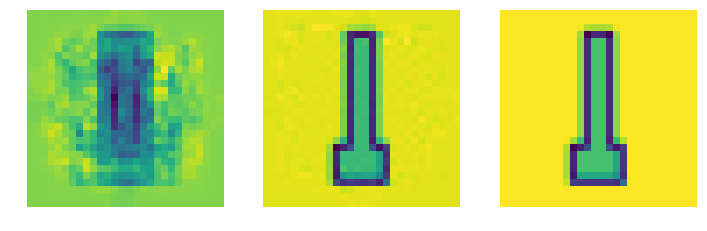

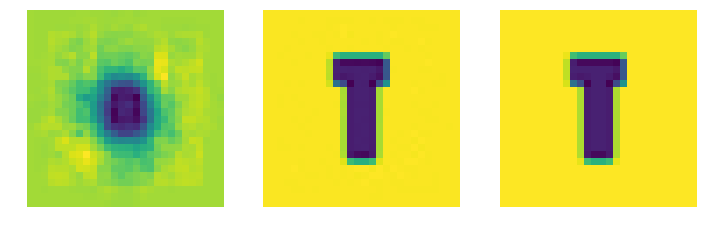

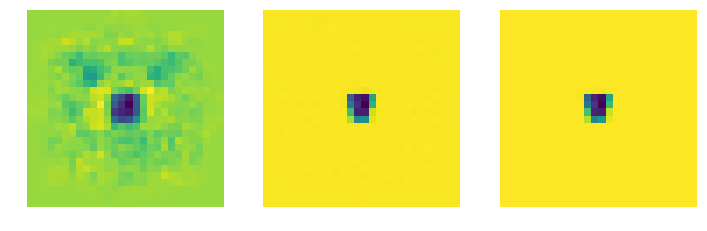

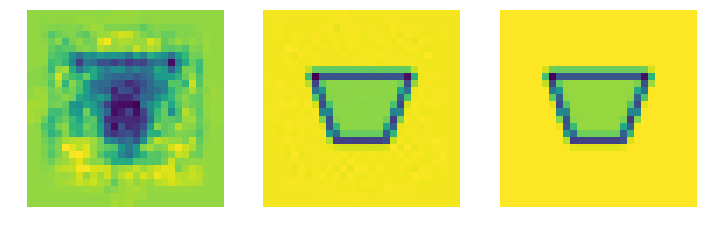

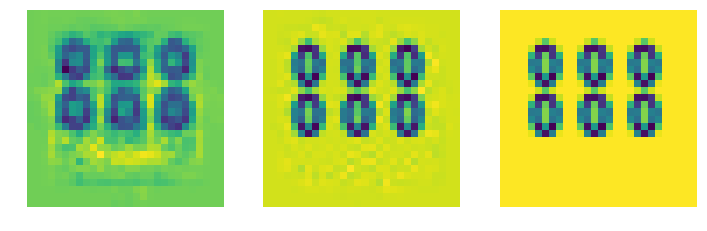

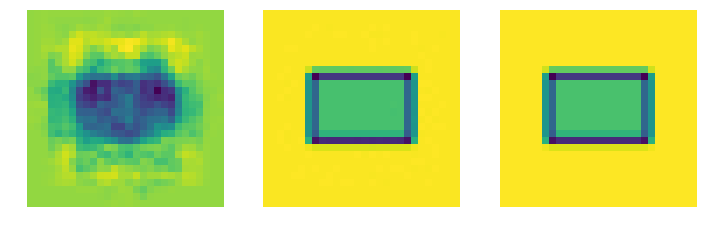

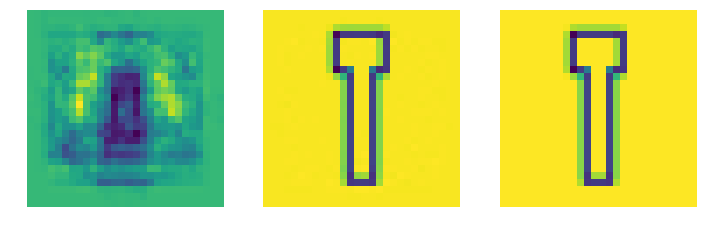

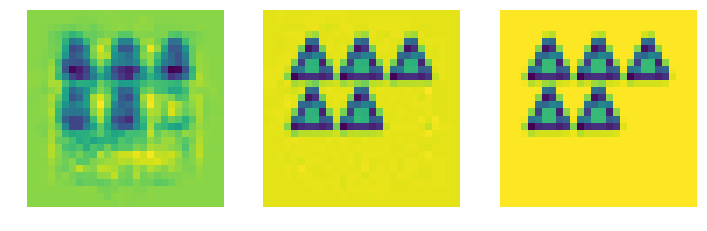

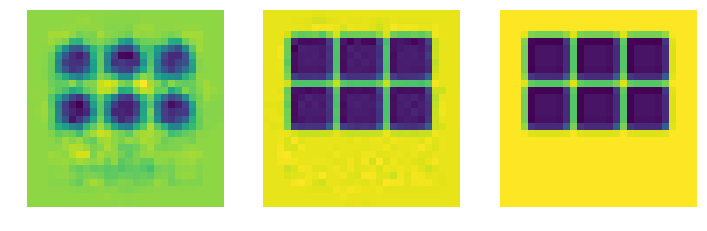

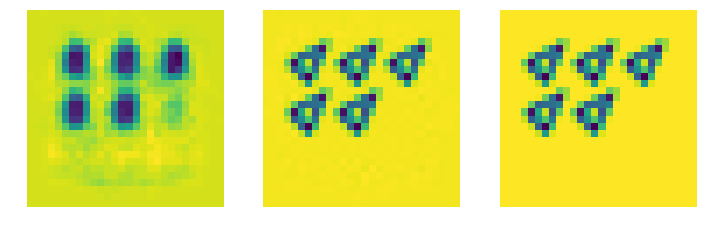

In [135]:
###############################
###### Plot some outputs ######
###############################

batch_size = 10
# test_data = SandiaDataProvider(which_set='valid', dataset_home='../../datasets/sandia/', img_size=img_size)

# Get a batch of validation images
(inputs, answers), correct_indices = next(test_data.get_batch_iterator(batch_size=batch_size,
                                                                       transpose_inputs=True,
                                                                       separate_inputs=True))

correct_answers = answers[range(batch_size), list(correct_indices)]
encoded_correct = enc.encode(correct_answers.reshape(batch_size, img_size ** 2))
encoded_correct = Variable(torch.Tensor(encoded_correct), requires_grad=False).cuda()

# Encode all inputs in the batch and resape back to batch_size, num_images, encoding_size
encoded_inputs = enc.encode(inputs.reshape(-1, img_size ** 2))
encoded_inputs = Variable(torch.Tensor(encoded_inputs.reshape(batch_size, -1, encoding_size)),
                          requires_grad=False).cuda()

prediction = best_model(encoded_inputs)


preds_dec = enc.decode(prediction.view(-1, encoding_size).cpu().data.numpy()).reshape(batch_size, img_size, img_size)
correct_dec = enc.decode(encoded_correct.cpu().data.numpy()).reshape(batch_size, img_size, img_size)

for pred, corr, dec in zip(preds_dec, correct_answers, correct_dec):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    
    axs[0].imshow(pred)
    axs[1].imshow(dec)    
    axs[2].imshow(corr)        

In [93]:
x.data.cpu().numpy().shape

(3, 8, 100)

In [29]:
i = 1
fig = plt.figure()
show_batch_of_images(inputs[i, :8], fig);
fig = plt.figure()
show_batch_of_images(enc.decode(encoded_inputs).reshape(batch_size, -1, img_size, img_size)[i, :9], fig);

NameError: name 'inputs' is not defined